### OCR Demo

In [1]:
import os
import cv2

from glob import glob
from tqdm import tqdm
from pathlib import Path
from natsort import natsorted

from BDRC.data import OpStatus
from BDRC.exporter import JsonExporter, PageXMLExporter, TextExporter
from BDRC.inference import OCRPipeline

from BDRC.utils import show_image, show_overlay, create_dir, get_filename, read_line_model_config, read_layout_model_config, read_ocr_model_config

In [2]:
data_path = "D:/Datasets/_dbu_can_val_data/Transcriptions"
output_dir = os.path.join(data_path, "Output")
create_dir(output_dir)

xml_exporter = PageXMLExporter(output_dir)
json_exporter = JsonExporter(output_dir)
text_exporter = TextExporter(output_dir)

img_ext = "png"
image_paths = natsorted(glob(f"{data_path}/*.{img_ext}"))

print(f"Images: {len(image_paths)}")

Images: 10


(320, 2005, 3)
D:/Datasets/_dbu_can_val_data/Transcriptions\16290115.png
16290115


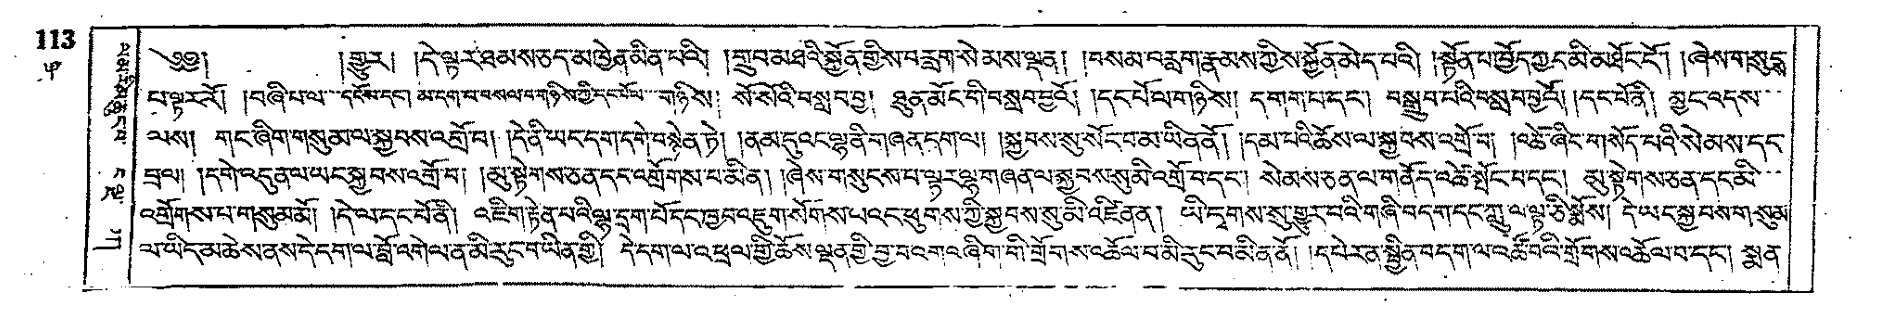

In [3]:
idx = 3
img = cv2.imread(image_paths[idx])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
print(image_paths[idx])
image_name = get_filename(image_paths[idx])
print(image_name)
show_image(img)

#### OCR via Pipelines using a line or layout model

In [4]:
# run download_al_models.py to download models and configs from HuggingFace

line_model_config_file = "Models/BDRC/PhotiLines/config.json"
layout_model_config_file = "Models/BDRC/Photi-v2/config.json"

line_model_config = read_line_model_config(line_model_config_file)
layout_model_config = read_layout_model_config(layout_model_config_file)
#modern_layout_model_config = read_layout_model_config(modern_layout_config_file)

In [5]:
# OCR pipeline with woodblock mdoel and layout model
#ocr_model_config_file = "Models/BDRC/Woodblock/model_config.json"
ocr_model_config_file = "Models/BDRC/BigUCHAN_v1/config.json"
ocr_model_config = read_ocr_model_config(ocr_model_config_file)
ocr_pipeline = OCRPipeline(ocr_model_config, line_model_config, False)

Available ONNX providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
*************** EP Error ***************
EP Error E:\_work\1\s\onnxruntime\python\onnxruntime_pybind_state.cc:560 onnxruntime::python::RegisterTensorRTPluginsAsCustomOps Please install TensorRT libraries as mentioned in the GPU requirements page, make sure they're in the PATH or LD_LIBRARY_PATH, and that your GPU is supported.
 when using ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
Falling back to ['CPUExecutionProvider'] and retrying.
****************************************
Available ONNX providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
*************** EP Error ***************
EP Error E:\_work\1\s\onnxruntime\python\onnxruntime_pybind_state.cc:560 onnxruntime::python::RegisterTensorRTPluginsAsCustomOps Please install TensorRT libraries as mentioned in the GPU requirements page, make sure they're in the PA

In [6]:
status, ocr_result = ocr_pipeline.run_ocr(img, k_factor=2.0, bbox_tolerance=2.5)

if status == OpStatus.SUCCESS:
    for ocr_line in ocr_result[2]:
        print(ocr_line.text)

else:
    print(status)
    print(ocr_result)

༄༅༎གྱུར༎དེ་ལྟར་ཐམས་ཅད་མཁྱེན་མིན་པརེ༎གྲུབ་མཐའི་སྐྱོན་གྱིས་བརླག་སེ་མས་ལྡན༎བསམ་བརླག་རྣམས་ཀྱིས་སྐྱོན་མེད་པའི༎སྟོན་པ་བྱེད་ཀྱད་མི་མཐོང་ངོ་༎ཞེས་གསུད་
ལྟརརོ༎བཞི་པ་ལ་དངོས་དང།མ་དག་པ་བསལ་བ་གཉིས་ཀྱི་དང་པོལ་གཉིས།སོ་སོའི་བསླབ་བྱ།ཐུན་མོང་གི་བསྲུབ་བྱའོ༎དང་པེལ་གཉིར།དགག་པ་དང་།བསྒྲུབ་པའི་བསླུཔ་བྱའོ༎དང་པོ་ནི།མྱུང་འདས་
།ལས།གང་ཞིག་གསུམ་ལ་སྐྱབས་འགྲོ་བ༎དེ་ནི་ཡང་དག་དགེ་བསྙེན་ཏེ༎ནམ་དུའང་ལྷནི་གཞན་དག་ལ༎སྐྱབས་སུ་སོང་བ་མ་ཡིན་ནོ༎དམ་པའི་ཆོས་ལ་སྐྱབས་འགྲོ་བ༎འཚེ་ཞིང་གསོད་པའི་སེམས་དད་།
༎དགེ་འདུནལ་ཡང་སྐྱབས་འགྲོ་བ༎མུ་སྟེགས་ཅན་དང་འགྲོགས་པ་མིན༎ཞེས་གསུངས་པ་ལྟར་ལྷ་གཞན་ལ་སྐྱབས་སུ་མི་འགྲོ་བ་དང་།སེམས་ཅན་ལ་གནོད་འཚེ་སྤོང་བ་དང་།མུ་སྟེགས་ཅན་དང་ཅོ་
།འགྲོགས་པ་གསུམ་མོ༎དེ་ལ་དང་པོ་ནི།འཇིག་རྟེན་པའི་ལྷ་དྲག་པོ་དང་ཁྱབ་འཇུག་སོགས་པའང་ཕུགས་ཀྱི་སྐྱབས་སུ་མི་འཛིན་ན་།མི་དྭགས་སུ་གྱུར་བའི་གཞི་བདག་དང་ཀླུ་ལ་ལྟ་ཅི་སྨོས།དེ་ཡང་སྐྱབས་གསུམ་།
།ལ་ཡིད་མཆེས་ནས་དེ་དགལ་བློ་འགེལ་ན་མི་རུང་བ་ཡིན་གྱི།དེ་དག་ལ་འཕྲལ་གྱི་ཆོས་ལྡན་གྱི་བྱ་བའགའ་ཞིག་གི་གྲོགས་འཆོལ་བ་མི་རུང་བ་མིན་ནོ༎དཔེར་ན་སྦྱིན་བདག་ལ་བཚོ་བའི་གྲོགས་འཆོལ་བ་དང་།སྨན་།


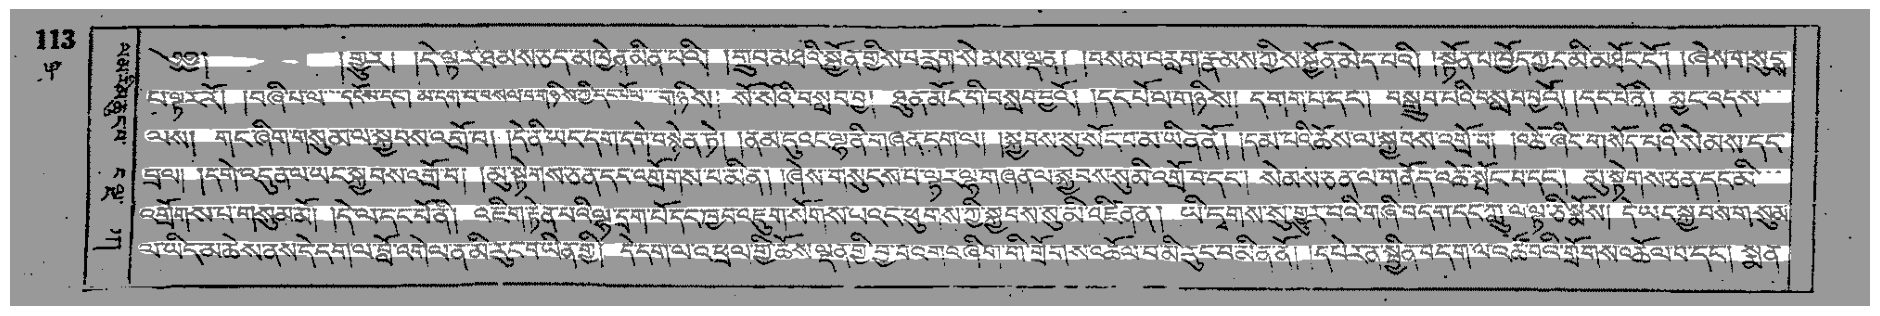

In [7]:
rot_mask, lines, ocr_lines, angle = ocr_result

show_overlay(img, rot_mask)

#### Single Volume

In [9]:
# single volume
#data_path = "C:/Users/Eric/Downloads/W23228"
#data_path = "D:/Datasets/_PIPELINE_ERRORS/W22393_error/W22393_img3-816"
data_path = "D:/Datasets/_dbu_can_val_data/Transcriptions"
output_dir = os.path.join(data_path, "Output")
create_dir(output_dir)

text_exporter = TextExporter(output_dir)
xml_exporter = PageXMLExporter(output_dir)

img_ext = "png"
image_paths = natsorted(glob(f"{data_path}/*.{img_ext}"))

if len(image_paths) > 0:
    for idx, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        image_name = get_filename(image_path)

        page_name = os.path.basename(image_path)
        base = os.path.splitext(page_name)[0]
        img = cv2.imread(image_path)
        status, ocr_result = ocr_pipeline.run_ocr(img, k_factor=2.0, bbox_tolerance=2.5)
        
        if status == OpStatus.SUCCESS:
            _, lines, ocr_lines, angle = ocr_result
            if len(ocr_result[2]) > 0:
                xml_exporter.export_lines(img, base, lines, ocr_lines, angle=angle)
                text_exporter.export_lines(img, base, lines, ocr_lines)

100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


#### Run Multiple Volumes

In [ ]:
# run on all data
ocr_model_config_file = "Models/BDRC/BigUCHAN_v1/config.json"
ocr_model_config = read_ocr_model_config(ocr_model_config_file)

work_id = "W22081_all"
root_dir = "C:/Users/Eric/Downloads/W22081_all"

output_dir = os.path.join(root_dir, "Output")
create_dir(output_dir)

ocr_pipeline = OCRPipeline(ocr_model_config, line_model_config, False)

for sub_dir in Path(root_dir).iterdir():
    if sub_dir.name == "Output":
        continue
    
    if f"{work_id}" in str(sub_dir) and os.path.isdir(sub_dir):

        volume_out = os.path.join(output_dir, str(sub_dir.name))

        if os.path.exists(volume_out):
            continue

        create_dir(volume_out)
        print(volume_out)
        text_exporter = TextExporter(volume_out)
        xml_exporter = PageXMLExporter(volume_out)

        img_ext = "tif"
        image_paths = natsorted(glob(f"{sub_dir}/*.{img_ext}"))
        print(f"{sub_dir.name} => Images: {len(image_paths)}")

        if len(image_paths) > 0:
            for idx, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
                page_name = os.path.basename(image_path)
                base = os.path.splitext(page_name)[0]
                img = cv2.imread(image_path)
                status, ocr_result = ocr_pipeline.run_ocr(img, k_factor=2.0, bbox_tolerance=2.5)

                if status == OpStatus.SUCCESS:
                    _, lines, ocr_lines, angle = ocr_result
                    if len(ocr_result[2]) > 0:
                        xml_exporter.export_lines(img, base, lines, ocr_lines, angle=angle)
                        text_exporter.export_lines(img, base, lines, ocr_lines)